# 说明

1.数据集来源为kaggle，因为是一个demo，且需要验证结果，所以仅取其训练集；
2.本项目主要为了说明构建一张简单的评分卡（A卡，也就是贷前）的过程，所以省略了EDA的部分，仅仅做一个简单的流程说明。
3.数据集和代码已经上传github：https://github.com/zzpl/Scorecard   欢迎star、fork

# 导入相关包

In [1]:
import numpy as np 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import math
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.preprocessing import LabelEncoder,OneHotEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix,roc_auc_score,roc_curve
import warnings
import plotly.express as px
import sklearn.metrics as metrics

warnings.filterwarnings('ignore')
plt.rcParams['font.family']='Microsoft YaHei' #显示中文标签
plt.style.use ('ggplot') #设定绘图风格
import seaborn as sns

pd.set_option('max_columns',1000)
pd.set_option('max_row',300)
pd.set_option('display.float_format', lambda x:' %.5f' % x)

# 数据集

## 导入数据

In [2]:
df_data = pd.read_csv(r'C:\Users\hp\Desktop\cs-training.csv',encoding='GB18030',index_col=0)
df_data.shape

(150000, 11)

## 查看数据集

In [3]:
df_data.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.76613,45,2,0.80298,9120.00000,13,0,6,0,2.00000
2,0,0.95715,40,0,0.12188,2600.00000,4,0,0,0,1.00000
3,0,0.65818,38,1,0.08511,3042.00000,2,1,0,0,0.00000
4,0,0.23381,30,0,0.03605,3300.00000,5,0,0,0,0.00000
5,0,0.90724,49,1,0.02493,63588.00000,7,0,1,0,0.00000


# 缺失值处理

## 查看数据缺失值

In [104]:
null_val_sums = df_data.isnull().sum()
pd.DataFrame({"特征名称": null_val_sums.index, "缺失值数目": null_val_sums.values,
             "缺失值占比": null_val_sums.values / len(df_data) })

,特征名称,缺失值数目,缺失值占比
0,SeriousDlqin2yrs,0,0.00000
1,RevolvingUtilizationOfUnsecuredLines,0,0.00000
2,age,0,0.00000
3,NumberOfTime30-59DaysPastDueNotWorse,0,0.00000
4,DebtRatio,0,0.00000
5,MonthlyIncome,29731,0.19821
6,NumberOfOpenCreditLinesAndLoans,0,0.00000
7,NumberOfTimes90DaysLate,0,0.00000
8,NumberRealEstateLoansOrLines,0,0.00000
9,NumberOfTime60-89DaysPastDueNotWorse,0,0.00000


## 缺失值填补

填补方法很多，比如给一个极端值-9999，或者分箱单独分为一箱，平均值填充，中位数填充等等，此处我们用中位数做简单填补

In [105]:
for i in null_val_sums.index:
    df_data[i] = df_data[i].fillna(df_data[i].median())

In [106]:
null_val_sums = df_data.isnull().sum()
pd.DataFrame({"特征名称": null_val_sums.index, "缺失值数目": null_val_sums.values,
             "缺失值占比": null_val_sums.values / len(df_data) })

,特征名称,缺失值数目,缺失值占比
0,SeriousDlqin2yrs,0,0.00000
1,RevolvingUtilizationOfUnsecuredLines,0,0.00000
2,age,0,0.00000
3,NumberOfTime30-59DaysPastDueNotWorse,0,0.00000
4,DebtRatio,0,0.00000
5,MonthlyIncome,0,0.00000
6,NumberOfOpenCreditLinesAndLoans,0,0.00000
7,NumberOfTimes90DaysLate,0,0.00000
8,NumberRealEstateLoansOrLines,0,0.00000
9,NumberOfTime60-89DaysPastDueNotWorse,0,0.00000


# 切分数据集

分为两部分，df_data1为建卡数据，参与模型的训练和测试，df_data2为验证数据，不参与任何过程。

In [107]:
df_data1, df_data2 = train_test_split(df_data, test_size=0.2, random_state=42,stratify=df_data['SeriousDlqin2yrs'])
df_data3 = df_data1

# 分箱

分箱有单独的分箱策略，比如有可能根据业务相关进行分箱，或者采取卡方分箱等等，此处采用qcut进行简单的等频分箱

In [108]:
'''
如果不是二分类，就将其等频分箱为4箱，如果有异常，则加入列表;
qcut按照等频方式分箱，且要求分位点处的取值唯一。
'''
for i in null_val_sums.index:
    pro_list = []
    if len(set(list(df_data1[i]))) > 2:
        try:
            df_data1[i] = pd.qcut(df_data1[i],4)
        except:
            pro_list.append(i)
print(pro_list)


['NumberOfDependents']


qcut当有多个元素有相同的分位点处取值时，就会报错,添加.rank(method='first')后还有问题，不想改了。。。用一次手动分箱

In [109]:
set(list(df_data1['NumberOfDependents']))

{0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 13.0, 20.0}

In [110]:
bins = [-math.inf ,2, 10, math.inf ]
df_data1['NumberOfDependents'] = pd.cut(df_data1['NumberOfDependents'],bins)

查看分箱后数据

In [111]:
df_data1

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
57837,0,"(0.0296, 0.153]","(52.0, 63.0]",0,"(0.861, 329664.0]","(3900.0, 5400.0]","(-0.001, 5.0]",0,1,0,"(-inf, 2.0]"
132896,0,"(-0.001, 0.0296]","(63.0, 109.0]",0,"(0.366, 0.861]","(-0.001, 3900.0]","(5.0, 8.0]",0,1,0,"(-inf, 2.0]"
27982,0,"(0.153, 0.558]","(-0.001, 41.0]",0,"(0.175, 0.366]","(-0.001, 3900.0]","(5.0, 8.0]",0,0,0,"(-inf, 2.0]"
37853,0,"(0.558, 50708.0]","(52.0, 63.0]",0,"(0.861, 329664.0]","(3900.0, 5400.0]","(-0.001, 5.0]",0,0,0,"(-inf, 2.0]"
103814,0,"(0.153, 0.558]","(52.0, 63.0]",0,"(0.861, 329664.0]","(-0.001, 3900.0]","(8.0, 11.0]",0,1,0,"(-inf, 2.0]"
...,...,...,...,...,...,...,...,...,...,...,...
18049,0,"(-0.001, 0.0296]","(-0.001, 41.0]",0,"(0.366, 0.861]","(7400.0, 3008750.0]","(8.0, 11.0]",0,2,0,"(-inf, 2.0]"
3896,0,"(-0.001, 0.0296]","(41.0, 52.0]",0,"(0.175, 0.366]","(7400.0, 3008750.0]","(11.0, 58.0]",0,1,0,"(-inf, 2.0]"
109981,0,"(0.558, 50708.0]","(63.0, 109.0]",0,"(0.861, 329664.0]","(3900.0, 5400.0]","(-0.001, 5.0]",0,0,0,"(-inf, 2.0]"
74355,0,"(0.558, 50708.0]","(52.0, 63.0]",0,"(0.366, 0.861]","(-0.001, 3900.0]","(-0.001, 5.0]",1,0,0,"(-inf, 2.0]"


# 计算IV值

#### 1 WOE

​		WOE的全称是“Weight of Evidence”，即证据权重。WOE是对原始自变量的一种编码形式。

​		要对一个变量进行WOE编码，需要首先把这个变量进行分组处理，对于第i组，WOE的计算公式如下：
$$
WOE_i = ln(\frac{py_i}{pn_i}) = ln(\frac{\frac{\#y_i}{\#y_T}}{\frac{\#n_i}{\#n_T}})
$$
​		$py_i$是这个组中违约客户占所有样本中所有违约客户的比例;

​		$pn_i$是这个组中未违约客户占样本中所有未违约客户的比例;

​		$\#y_i$是这个组中违约客户的数量;

​		$\#n_i$是这个组中未违约客户的数量;

​		$\#y_T$是样本中所有违约客户的数量;

​		$\#n_T$是样本中所有未违约客户的数量。


​		WOE表示的实际上是“当前分组中违约客户占所有违约客户的比例”和“当前分组中没有违约的客户占所有没有违约的客户的比例”的差异。

​		
$$
WOE_i = ln(\frac{py_i}{pn_i}) = ln(\frac{\frac{\#y_i}{\#y_T}}{\frac{\#n_i}{\#n_T}}) = ln(\frac{\frac{\#y_i}{\#n_i}}{\frac{\#Y_T}{\#n_T}})
$$
​		变换后，WOE表示的是当前这个组中坏客户和好客户的比值a，和所有样本中这个比值b的差异。这个差异是用这两个比值的比值，再取对数来表示的。WOE越大，这种差异越大，这个分组里的样本违约的可能性就越大，WOE越小，差异越小，这个分组里的样本违约的可能性就越小。
#### 2 IV的计算公式

​		IV值代表该变量包含的信息量的大小，即该特征对模型的影响程度；对于分组i，也会有一个对应的IV值，计算公式如下：
$$
IV_i = (py_i-pn_i)*WOE_i=(py_i-pn_i)*ln(\frac{py_i}{pn_i})=(\frac{\#y_i}{\#y_T}-\frac{\#n_i}{\#n_T})*ln(\frac{\frac{\#y_i}{\#y_T}}{\frac{\#n_i}{\#n_T}})
$$
​		计算整个变量的IV值，将把各分组的IV相加：
$$
IV=\sum_i^nIV_i
$$
​		n为变量分组个数。

In [112]:
def cal_IV(df, feature, target):
    lst = []
    cols=['Variable', 'Value', 'All', 'Bad']
    for i in range(df[feature].nunique()):
        
        val = list(df[feature].unique())[i]
        lst.append([feature, val, df[df[feature] == val].count()[feature], df[(df[feature] == val) & (df[target] == 1)].count()[feature]])
    data = pd.DataFrame(lst, columns=cols)
    data = data[data['Bad'] > 0]

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Bad'] / data['Distribution Good'])
    data['IV'] = (data['WoE'] * (data['Distribution Bad'] - data['Distribution Good'])).sum()

    data = data.sort_values(by=['Variable', 'Value'], ascending=True)

    return data['IV'].values[0]

我们把IV小于0.02的看作无效特征；IV大于0.02，小于0.1的为弱效果特征；IV大于0.1，小于0.3中等效果特征；IV大于0.3，小于0.5为强特征，大于0.5为特强特征；
因为特征不多，此处我们取所以iv值>0.02的特征

In [113]:
'''
循环计算每列数据的iv值，并进行如下操作方便后续使用：
1.将iv值>0.02的列名称存入列表，并输出
2.按照iv值降序排列，并输出一个dataframe，方便保存使用
'''
feature_list = []
iv_list = []
cols = [c for c in df_data1.columns.values]
for f in cols:
    iv = cal_IV(df_data1,f,'SeriousDlqin2yrs')
    if 1000>iv>=0.02:
        iv_list.append(iv)
        feature_list.append(f)
print(feature_list)
combine_data ={'特征名称':feature_list,'IV值':iv_list}
fea_iv_data = pd.DataFrame(combine_data) 
fea_iv_data = fea_iv_data.sort_values(by="IV值" , ascending=False)
fea_iv_data

['RevolvingUtilizationOfUnsecuredLines', 'age', 'DebtRatio', 'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans']


,特征名称,IV值
0,RevolvingUtilizationOfUnsecuredLines,1.01656
1,age,0.23428
3,MonthlyIncome,0.05832
4,NumberOfOpenCreditLinesAndLoans,0.03941
2,DebtRatio,0.02268


# WOE编码

In [114]:
def cal_WOE(df,features,target):
    df_new = df
    for f in features:
        df_woe = df_new.groupby(f).agg({target:['sum','count']})
        df_woe.columns = list(map(''.join, df_woe.columns.values))
        df_woe = df_woe.reset_index()
        df_woe = df_woe.rename(columns = {target+'sum':'bad'})
        df_woe = df_woe.rename(columns = {target+'count':'all'})
        df_woe['good'] = df_woe['all']-df_woe['bad']
        df_woe = df_woe[[f,'good','bad']]
        df_woe['bad_rate'] = df_woe['bad'].mask(df_woe['bad']==0, 1)/df_woe['bad'].sum() # mask 0 to 1 to avoid log(0)
        df_woe['good_rate'] = df_woe['good']/df_woe['good'].sum()
        
        df_woe['woe'] = np.log(df_woe['bad_rate'].divide(df_woe['good_rate'],fill_value=1))
        df_woe.columns = [c if c==f else c+'_'+f for c in list(df_woe.columns.values)]
        df_new = df_new.merge(df_woe,on=f,how='left')
    return df_new

In [115]:
feature_cols=feature_list
df_woe = cal_WOE(df_data1,feature_cols,'SeriousDlqin2yrs')
woe_cols = [c for c in list(df_woe.columns.values) if 'woe' in c]
df_woe[woe_cols]

,woe_RevolvingUtilizationOfUnsecuredLines,woe_age,woe_DebtRatio,woe_MonthlyIncome,woe_NumberOfOpenCreditLinesAndLoans
0,-1.23536,-0.20671,0.01262,-0.02732,0.25590
1,-1.34985,-0.98986,0.21988,0.32355,-0.23623
2,-0.31735,0.45732,-0.17536,0.32355,-0.23623
3,1.11424,-0.20671,0.01262,-0.02732,0.25590
4,-0.31735,-0.20671,0.01262,0.32355,-0.13110
...,...,...,...,...,...
119995,-1.34985,0.45732,0.21988,-0.35836,-0.13110
119996,-1.34985,0.19653,-0.17536,-0.35836,-0.03721
119997,1.11424,-0.98986,0.01262,-0.02732,0.25590
119998,1.11424,-0.20671,0.21988,0.32355,0.25590


# 相关性检验

两个特征如果相关系>0.5,保留IV值大的特征即可

In [116]:
df_woe[woe_cols].corr()

,woe_RevolvingUtilizationOfUnsecuredLines,woe_age,woe_DebtRatio,woe_MonthlyIncome,woe_NumberOfOpenCreditLinesAndLoans
woe_RevolvingUtilizationOfUnsecuredLines,1.00000,0.25947,0.11174,0.08867,0.11602
woe_age,0.25947,1.00000,0.04495,0.04186,0.04374
woe_DebtRatio,0.11174,0.04495,1.00000,0.08234,-0.11612
woe_MonthlyIncome,0.08867,0.04186,0.08234,1.00000,0.16082
woe_NumberOfOpenCreditLinesAndLoans,0.11602,0.04374,-0.11612,0.16082,1.00000


其实还可以采用一些其他特征筛选策略进行组合筛选，因为这个数据集特征本身就少，就不做进一步筛选了

# 输出每个分箱的woe编码值

In [117]:
df_bin_to_woe = pd.DataFrame(columns = ['features','bin','woe'])
for f in feature_cols:
    b = f
    w = 'woe_'+f
    df = df_woe[[w,b]].drop_duplicates()
    df.columns = ['woe','bin']
    df['features'] = f
    df=df[['features','bin','woe']]
    df_bin_to_woe = pd.concat([df_bin_to_woe,df])
df_bin_to_woe

,features,bin,woe
0,RevolvingUtilizationOfUnsecuredLines,"(0.0296, 0.153]",-1.23536
1,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0296]",-1.34985
2,RevolvingUtilizationOfUnsecuredLines,"(0.153, 0.558]",-0.31735
3,RevolvingUtilizationOfUnsecuredLines,"(0.558, 50708.0]",1.11424
0,age,"(52.0, 63.0]",-0.20671
1,age,"(63.0, 109.0]",-0.98986
2,age,"(-0.001, 41.0]",0.45732
8,age,"(41.0, 52.0]",0.19653
0,DebtRatio,"(0.861, 329664.0]",0.01262
1,DebtRatio,"(0.366, 0.861]",0.21988


# 模型建立

## 数据集切分

In [118]:
X_train, X_test, y_train, y_test = train_test_split(df_woe[woe_cols], df_woe['SeriousDlqin2yrs'], test_size=0.2, random_state=42,stratify=df_woe['SeriousDlqin2yrs'])
print('坏样本占比为： ',y_train.mean())

坏样本占比为：  0.06684375


## 建立逻辑回归模型

In [119]:
model = LogisticRegression(C=1,penalty='l2',random_state=42,class_weight ='balanced').fit(X_train,y_train)
model.score(X_test,y_test)

0.7429583333333334

## 模型评价标准

1.AUC：AUC为ROC曲线的面积，取值为[0，1]，越接近1证明模型预测效果越好。ROC曲线的纵坐标轴为TPR；横坐标轴为FPR。一般AUC>0.8证明效果还可以，可以考虑上线。
2.KS值：衡量的是好坏样本累计分布之间的差值。好坏样本累计差异越大，KS指标越大，那么模型的风险区分能力越强，当KS值>0.4，且训练集和测试集相差不超过5%，正负样本区分度还不错。

ks_test: 0.45781042125887284
ks_train: 0.4512379019935372


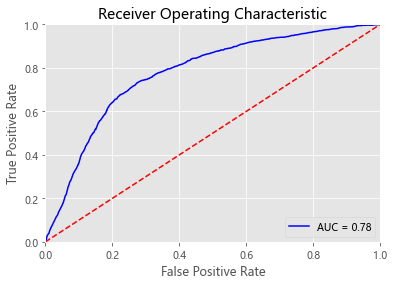

In [120]:
probs = model.predict_proba(X_test)

preds = probs[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)
ks=abs(fpr-tpr).max()
print('ks_test:',ks)

probs_train = model.predict_proba(X_train)

preds_train = probs_train[:,1]
fpr_train, tpr_train,_= metrics.roc_curve(y_train, preds_train)

ks_train=abs(fpr_train-tpr_train).max()
print('ks_train:',ks_train)


plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

可以看出，AUC=0.78效果不太好，一般可以通过特征交叉、新增特征，调整分箱等等方法去达到更好的效果。因为是示例，我们就继续向下走，暂时不做调整

In [121]:
model.coef_

array([[0.91782126, 0.53825662, 0.61381409, 0.49520852, 0.09039349]])

In [122]:
y_pred = model.predict(X_test)
metrics.confusion_matrix(y_test,y_pred)

array([[16695,  5701],
       [  468,  1136]], dtype=int64)

# 基于Logistic回归的评分卡转换

#### 评分卡转换原理

​		客户违约概率为p，正常概率为1-p，违约概率与正常概率的比值，称为Odds，即：
$$
Odds=\frac{p}{1-p}    ----(1)
$$

逻辑回归公式为：
$$
p=\frac{1}{1+e^-\theta^Tx} ----   (2)
$$
同时取ln
$$
ln(\frac{p}{1-p})=\theta^Tx  ---- (3) 
$$
将公式（1）代入（3）,即：
$$
ln(Odds)=\theta^Tx   ----(4)
$$
评分卡的背后逻辑是Odds的变动与评分变动的映射（把Odds映射为评分），即通过下述公式进行映射：
$$
Score=A-B*ln（Odds）----（5）
$$
其中A与B是常数，B前面取负号的原因，是让违约概率越低，得分越高。因为实际业务里，分数也高风险越低，风控里默认高分高信用低风险
计算出A、B的方法如下：
1. 设定基准分。基准分为$A-B*\theta_0$，也就是$p_0$，当odds无变动时，$\theta_0$=1，A=$p_0$,此处我们设定基础分为650；
2. PDO（point of double），比率翻番时分数的变动值。此处设置为当odds翻倍时，分值减少50。
由上述可得：
$$
P_0=A-B*ln(\theta_0)
$$
根据PDO的定义，有下面等式：
$$
P_0-PDO=A-B*ln(2\theta_0)
$$
上述两个等式联立求解

可得：
$$
B=\frac{PDO}{ln2}\\
A=P_0+B*ln(\theta_0)
$$
评分卡里每一个变量x的每一个分箱有一个对应分值，即将每个特征的重要性权值与特征分箱的WOE编码进行结合计算，其计算方法如下：

$$
Score=A-B\{\theta_i\omega_{ij}\}
$$
其中，$\theta_i$表示第i个特征的重要性得分,$\omega_{ij}$表示第i个特征的第j个分箱的WOE编码的分数。

In [23]:
A = 650
B =72.13
def generate_scorecard(model_coef,binning_df,features,B):
    lst = []
    cols = ['Variable','Binning','Score']
    coef = model_coef[0]
    for i in range(len(features)):
        f = features[i]
        df = binning_df[binning_df['features']==f]
        for index,row in df.iterrows():
            lst.append([f,row['bin'],int(round(-coef[i]*row['woe']*B))])
    data = pd.DataFrame(lst, columns=cols)
    return data

# 评分卡说明

一般来说，第一版评分卡出来之后就要看每个特征分箱对应的得分业务上是否能够解释，解释性差的话，可以考虑重新分箱,因为比较麻烦，这里不再做调整了

In [24]:
score_card = generate_scorecard(model.coef_,df_bin_to_woe,feature_cols,B)
sort_scorecard = score_card.groupby('Variable').apply(lambda x: x.sort_values('Score', ascending=False))
sort_scorecard

Variable  \
Variable                                                                        
DebtRatio                            10                             DebtRatio   
                                     11                             DebtRatio   
                                     8                              DebtRatio   
                                     9                              DebtRatio   
MonthlyIncome                        14                         MonthlyIncome   
                                     15                         MonthlyIncome   
                                     12                         MonthlyIncome   
                                     13                         MonthlyIncome   
NumberOfOpenCreditLinesAndLoans      17       NumberOfOpenCreditLinesAndLoans   
                                     18       NumberOfOpenCreditLinesAndLoans   
                                     19       NumberOfOpenCreditLinesAndLoans   
                                     16       NumberOfOpenCreditLinesAndLoans   
RevolvingUtilizationOfUnsecuredLines 1   RevolvingUtilizationOfUnsecuredLines   
                                     0   RevolvingUtilizationOfUnsecuredLines   
                                     2   RevolvingUtilizationOfUnsecuredLines   
                                     3   RevolvingUtilizationOfUnsecuredLines   
age                                  5                                    age   
                                     4                                    age   
                                     7                                    age   
                                     6                                    age   

                                                     Binning  Score  
Variable                                                             
DebtRatio                            10       (0.175, 0.366]      8  
                                     11      (-0.001, 0.175]      4  
                                     8     (0.861, 329664.0]     -1  
                                     9        (0.366, 0.861]    -10  
MonthlyIncome                        14  (7400.0, 3008750.0]     13  
                                     15     (5400.0, 7400.0]      2  
                                     12     (3900.0, 5400.0]      1  
                                     13     (-0.001, 3900.0]    -12  
NumberOfOpenCreditLinesAndLoans      17           (5.0, 8.0]      2  
                                     18          (8.0, 11.0]      1  
                                     19         (11.0, 58.0]      0  
                                     16        (-0.001, 5.0]     -2  
RevolvingUtilizationOfUnsecuredLines 1      (-0.001, 0.0296]     89  
                                     0       (0.0296, 0.153]     82  
                                     2        (0.153, 0.558]     21  
                                     3      (0.558, 50708.0]    -74  
age                                  5         (63.0, 109.0]     38  
                                     4          (52.0, 63.0]      8  
                                     7          (41.0, 52.0]     -8  
                                     6        (-0.001, 41.0]    -18

In [25]:
score_card

,Variable,Binning,Score
0,RevolvingUtilizationOfUnsecuredLines,"(0.0296, 0.153]",82
1,RevolvingUtilizationOfUnsecuredLines,"(-0.001, 0.0296]",89
2,RevolvingUtilizationOfUnsecuredLines,"(0.153, 0.558]",21
3,RevolvingUtilizationOfUnsecuredLines,"(0.558, 50708.0]",-74
4,age,"(52.0, 63.0]",8
5,age,"(63.0, 109.0]",38
6,age,"(-0.001, 41.0]",-18
7,age,"(41.0, 52.0]",-8
8,DebtRatio,"(0.861, 329664.0]",-1
9,DebtRatio,"(0.366, 0.861]",-10


# 按照上述评分卡给建卡数据、验证数据打分

## 得分映射函数

因为只有五个特征，这里采用比较笨蛋的写法

In [48]:
def no1(a):
    a = float(a)
    if a <=0.0296:
        return 89
    elif a<=0.153:
        return 82
    elif a<=0.558:
        return 21
    else:
        return -74
def no2(a):
    if a <=41:
        return -18
    elif a<=52.0:
        return -8
    elif a<= 63.0:
        return 8
    else:
        return 38
def no3(a):
    if a <= 0.175:
        return 4
    elif a<=0.366:
        return 8
    elif a<=0.861:
        return -10
    else:
        return -1
def no4(a):
    if a <=3900.0:
        return -12
    elif a<=5400.0:
        return 1
    elif a<= 7400.0:
        return 2
    else:
        return 13
def no5(a):
    if a <=5.0:
        return -2
    elif a<=8.0:
        return 2
    elif a<=11.0:
        return 1
    else:
        return 0

 ## 对建卡数据进行得分映射

In [57]:
df_data3['R_score'] = df_data3.apply(lambda x: no1(x.RevolvingUtilizationOfUnsecuredLines), axis = 1)
df_data3['age_score'] = df_data3.apply(lambda x: no2(x.age), axis = 1)
df_data3['D_score'] = df_data3.apply(lambda x: no3(x.DebtRatio), axis = 1)
df_data3['M_score'] = df_data3.apply(lambda x: no4(x.MonthlyIncome), axis = 1)
df_data3['N_score'] = df_data3.apply(lambda x: no5(x.NumberOfOpenCreditLinesAndLoans), axis = 1)


In [62]:
df_1 = df_data1.iloc[:,-5:-1]
df_2 = df_data1.iloc[:,-1]
df_s1 = pd.concat([df_1,df_2], axis=1)
df_s1['总分'] = df_s1.sum(axis = 1) 
df_s1 = pd.concat([df_s1,df_data3['SeriousDlqin2yrs']], axis=1)
df_s1.head()


,R_score,age_score,D_score,M_score,N_score,总分,SeriousDlqin2yrs
57837,82,8,-1,1,-2,88,0
132896,89,38,-10,-12,2,107,0
27982,21,-18,8,-12,2,1,0
37853,-74,8,-1,1,-2,-68,0
103814,21,8,-1,-12,1,17,0


In [63]:
print ('好样本得分区间',df_s1[df_s1['SeriousDlqin2yrs'] == 0][['总分']].min(),df_s1[df_s1['SeriousDlqin2yrs'] == 0][['总分']].max()) 
print ('坏样本得分区间',df_s1[df_s1['SeriousDlqin2yrs'] == 1][['总分']].min(),df_s1[df_s1['SeriousDlqin2yrs'] == 1][['总分']].max()) 

好样本得分区间 总分   -116
dtype: int64 总分    150
dtype: int64
坏样本得分区间 总分   -116
dtype: int64 总分    150
dtype: int64


## 对验证数据进行得分映射

In [64]:
df_data2['R_score'] = df_data2.apply(lambda x: no1(x.RevolvingUtilizationOfUnsecuredLines), axis = 1)
df_data2['age_score'] = df_data2.apply(lambda x: no2(x.age), axis = 1)
df_data2['D_score'] = df_data2.apply(lambda x: no3(x.DebtRatio), axis = 1)
df_data2['M_score'] = df_data2.apply(lambda x: no4(x.MonthlyIncome), axis = 1)
df_data2['N_score'] = df_data2.apply(lambda x: no5(x.NumberOfOpenCreditLinesAndLoans), axis = 1)

In [69]:
df_3 = df_data2.iloc[:,-5:-1]
df_4 = df_data2.iloc[:,-1]
df_s2 = pd.concat([df_3,df_4], axis=1)
df_s2['总分'] = df_s2.sum(axis = 1) 
df_s2 = pd.concat([df_s2,df_data2['SeriousDlqin2yrs']], axis=1)
df_s2.head()


,R_score,age_score,D_score,M_score,N_score,总分,SeriousDlqin2yrs
10683,89,38,-10,1,0,118,0
40174,21,38,-1,-12,2,48,0
4720,82,8,4,13,-2,105,0
81731,82,8,-10,13,1,94,0
113640,82,38,-10,2,0,112,0


In [70]:
print ('好样本得分区间',df_s2[df_s2['SeriousDlqin2yrs'] == 0][['总分']].min(),df_s2[df_s2['SeriousDlqin2yrs'] == 0][['总分']].max()) 
print ('坏样本得分区间',df_s2[df_s2['SeriousDlqin2yrs'] == 1][['总分']].min(),df_s2[df_s2['SeriousDlqin2yrs'] == 1][['总分']].max()) 

好样本得分区间 总分   -116
dtype: int64 总分    150
dtype: int64
坏样本得分区间 总分   -116
dtype: int64 总分    143
dtype: int64


# 评估

## 首先查看建卡数据的得分分布

比较好的分布图肯定是两个单峰，且好用户和坏用户交叉不多，目前这个由于上述各种偷懒操作且特征本身也不多，效果并不理想，但是可以继续向下走流程。

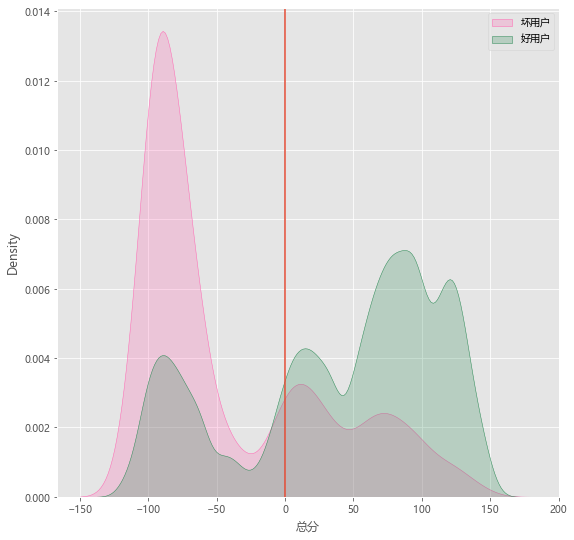

In [77]:
# 得分分布图
def plot_score_hist(df,target,score_col,plt_size=None,cutoff=None):
    """
    df:数据集
    target:目标变量的字段名
    score_col:最终得分的字段名
    plt_size:图纸尺寸
    cutoff :划分拒绝/通过的点
    
    return :好坏用户的得分分布图
    """    
    plt.figure(figsize=plt_size)
    x1 = df[df[target]==1][score_col]
    x2 = df[df[target]==0][score_col]
    sns.kdeplot(x1,shade=True,label='坏用户',color='hotpink')
    sns.kdeplot(x2,shade=True,label='好用户',color ='seagreen')
    plt.axvline(x=cutoff)
    plt.legend()
    return plt.show()
plot_score_hist(df_s1,'SeriousDlqin2yrs','总分',plt_size=(9,9),cutoff=0)

## 搜索CUTOFF

对于评分卡来说，需要有一条线或者说是一个得分点来对数据进行切分此出先将其称为Cutoff，高于这条线，接受，低于则拒绝
下面通过寻找KS值最大的点进行一个粗筛，实际业务还会根据通过率、坏样本累计占比等因素进行调整。

In [73]:
def search_cutoff(df,col_score,target):
    
    cutoff = list(range(-150, 151))
    refuse_acc=[]
    tpr_ls=[]
    fpr_ls=[]
    KS_ls=[]
    for i in cutoff:
        df['result'] = df.apply(lambda x:'拒绝' if x[col_score]<=i else '接受',axis=1)
        TP = df[(df['result']=='拒绝')&(df[target]==1)].shape[0] 
        FN = df[(df['result']=='拒绝')&(df[target]==0)].shape[0] 
        bad = df[df[target]==1].shape[0] 
        good = df[df[target]==0].shape[0] 
        refuse = df[df['result']=='拒绝'].shape[0] 
        passed = df[df['result']==10].shape[0] 
        tpr = round(TP/bad,3) 
        fpr = round(FN/good,3) 
        KS = abs(tpr-fpr)
        KS_ls.append(KS)
        
    maxid_KS = KS_ls.index(max(KS_ls))
    co4 = cutoff[maxid_KS]
    print('最大KS值:{}'.format(max(KS_ls)))
    print('KS最大的分数:{}'.format(co4))                     

    return 

search_cutoff(df_s1,'总分','SeriousDlqin2yrs')

最大KS值:0.45100000000000007
KS最大的分数:-21


In [74]:
# 设定cutoff点，衡量有效性
def rule_verify(df,col_score,target,cutoff):
    """
    df:数据集
    target:目标变量的字段名
    col_score:最终得分的字段名    
    cutoff :划分拒绝/通过的点
    
    return :混淆矩阵
    """
    df['result'] = df.apply(lambda x:'拒绝' if x[col_score]<=cutoff else '接受',axis=1)
    TP = df[(df['result']=='拒绝')&(df[target]==1)].shape[0] 
    FN = df[(df['result']=='拒绝')&(df[target]==0)].shape[0] 
    bad = df[df[target]==1].shape[0] 
    good = df[df[target]==0].shape[0] 
    refuse = df[df['result']=='拒绝'].shape[0] 
    passed = df[df['result']==10].shape[0] 
     
    acc = round(TP/refuse,3) 
    tpr = round(TP/bad,3) 
    fpr = round(FN/good,3) 
    pass_rate = round(refuse/df.shape[0],3) 
    matrix_df = pd.pivot_table(df,index='result',columns=target,aggfunc={col_score:pd.Series.count},values=col_score) 
    
    print('拒绝准确率:{}'.format(acc))
    print('查全率:{}'.format(tpr))
    print('误伤率:{}'.format(fpr))
    print('规则拒绝率:{}'.format(pass_rate))
    return matrix_df

rule_verify(df_s1,'总分','SeriousDlqin2yrs',-21)

拒绝准确率:0.179
查全率:0.67
误伤率:0.219
规则拒绝率:0.25


SeriousDlqin2yrs,0,1
result,,
拒绝,24575,5372
接受,87404,2649


可以看出，这张卡可以拒绝掉大部分的坏样本，但是也会有21.9%的好样本被误伤

## 再看下在验证数据上的结果

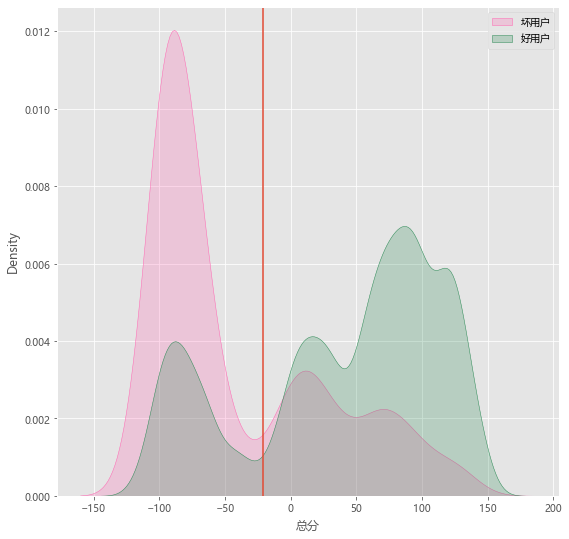

In [78]:
plot_score_hist(df_s2,'SeriousDlqin2yrs','总分',plt_size=(9,9),cutoff=-21)

In [79]:
rule_verify(df_s2,'总分','SeriousDlqin2yrs',-21)

拒绝准确率:0.177
查全率:0.665
误伤率:0.222
规则拒绝率:0.252


SeriousDlqin2yrs,0,1
result,,
拒绝,6219,1333
接受,21776,672


可以看出，这张评分卡在验证数据上和建卡数据效果相差不大，大概75%的通过率，同时，也能够识别出大部分的坏样本。
由于数据集原因，这张卡做到这里就结束了，个人也属于相关初学者，如有错误疏漏，欢迎指出，一起学习探讨